# Venn-ABERS calibration

This notebook gives an implementation example of Venn-ABERS calibration for binary classification problems. 

Venn-ABERS calibration is decribed in more detail in:

 - Vovk, Vladimir, Ivan Petej, and Valentina Fedorova. "Large-scale probabilistic predictors with and without guarantees of validity." Advances in Neural Information Processing Systems 28 (2015) (arxiv version https://arxiv.org/pdf/1511.00213.pdf)
 - Vovk, Vladimir, Ivan Petej "Venn-Abers predictors". Proceedings of the Thirtieth Conference on Uncertainty in Artificial Intelligence (2014) (arxiv version https://arxiv.org/abs/1211.0025)

In [12]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.calibration import CalibrationDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss, accuracy_score, brier_score_loss

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

import calibration as cal

from venn_abers import VennAbersCalibrator, VennAbers

## Basic usage

### Create binary classificiation dataset

In [13]:
from run_chil_exp import read_data


np.random.seed(seed=42)

mimic_size = "full_mimic3"
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = read_data(
    "mimic3_mort_hosp", random_seed=RANDOM_SEED, mimic_size=mimic_size
)

Random Forest Hyperparameters

In [14]:
N_EST = 300
MAX_DEPTH = 10
MIN_SAMPLES_SPLIT = 3
MIN_SAMPLES_LEAF = 1

### Applying Venn-ABERS calibration to an underlying scikit learn classifier

In [15]:
# underlying classifier
clf = RandomForestClassifier(
    n_estimators=N_EST,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
)
clf.fit(X_train, y_train)
clf_prob = clf.predict_proba(X_test)

# Inductive Venn-ABERS calibration (IVAP)
va = VennAbersCalibrator(estimator=clf, inductive=True, cal_size=0.2, shuffle=False)
va.fit(X_train, y_train)
va_inductive_prob = va.predict_proba(X_test)

# Cross Venn-ABERS calibration (CVAP)
va = VennAbersCalibrator(estimator=clf, inductive=False, n_splits=2)
va.fit(X_train, y_train)
va_cv_prob = va.predict_proba(X_test)

# Pre-fitted Venn-ABERS calibration
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

clf.fit(X_train_proper, y_train_proper)
p_cal = clf.predict_proba(X_cal)
p_test = clf.predict_proba(X_test)

va = VennAbersCalibrator()
va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_cal, p_test=p_test)



log_losses=[]
log_losses.append(log_loss(y_test, clf_prob))
log_losses.append(log_loss(y_test, va_inductive_prob))
log_losses.append(log_loss(y_test, va_cv_prob))
log_losses.append(log_loss(y_test, va_prefit_prob))


df_loss = pd.DataFrame(columns=['Metric', 'Uncalibrated', 'IVAP', 'CVAP', 'Prefit'])
df_loss.loc[1] = ['log loss'] + log_losses
df_loss.set_index('Metric', inplace=True)
df_loss.round(3)

,Uncalibrated,IVAP,CVAP,Prefit
Metric,,,,
log loss,0.216,0.206,0.205,0.206


Venn-ABERS calibrators improve log losses in this example

## Comparison with Platt and Isotonic Calibration

Here we run a comparison between Venn-ABERS calibration and two other popular calibration methods, namely Platt and Isotonic (available in scikit learn)

In [22]:
# Create classifiers
nb = RandomForestClassifier(
    n_estimators=N_EST,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
)
nb_isotonic = CalibratedClassifierCV(estimator=nb, cv=3, method="isotonic")
nb_sigmoid = CalibratedClassifierCV(estimator=nb, cv=3, method='sigmoid')
nb_vennabers =  VennAbersCalibrator(estimator=nb, inductive=True, n_splits=3, precision=4)


clf_list = [
    (nb, "Naive Bayes"),
    (nb_isotonic, "Naive Bayes - Isotonic"),
    (nb_sigmoid, "Naive Bayes - Platt"),
    (nb_vennabers, "Naive Bayes - VennABERS"),
]

In [23]:
from califorest import metrics as em
from sklearn.metrics import roc_auc_score

### Plot calibration curves

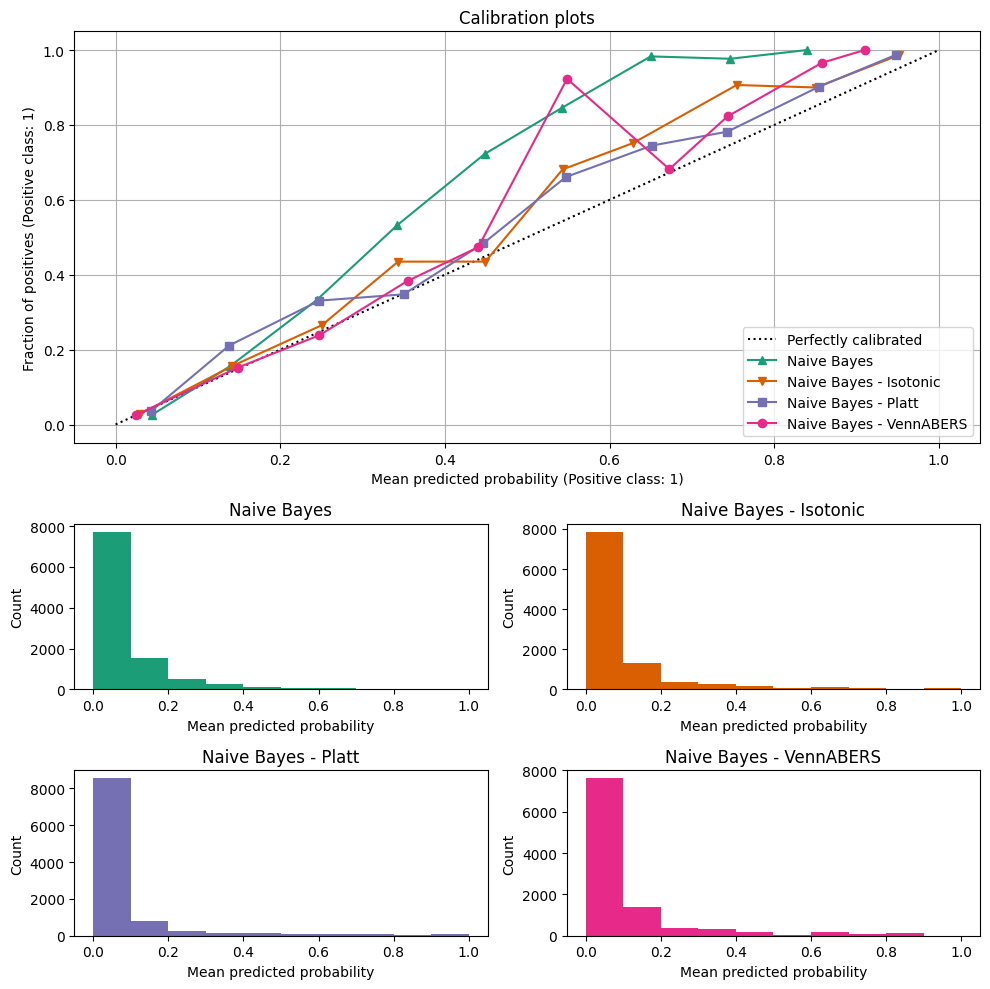

In [24]:

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

metrics_list = []
metrics_list2 = []

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:,1]
    l_loss = log_loss(y_test, y_prob)
    brier_loss = brier_score_loss(y_test, y_prob)
    calibration_error = cal.get_calibration_error(y_prob, y_test)
    
    score_auc = roc_auc_score(y_test, y_prob)
    score_hl = em.hosmer_lemeshow(y_test, y_prob)
    score_sh = em.spiegelhalter(y_test, y_prob)
    score_b, score_bs = em.scaled_brier_score(y_test, y_prob)
    rel_small, rel_large = em.reliability(y_test, y_prob)
    if name != "Naive Bayes - VennABERS":
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        metrics_list.append([name, acc, brier_loss, l_loss, calibration_error])
        metrics_list2.append([name, score_auc, score_hl, score_sh, score_b, score_bs, rel_small, rel_large])
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i],
        )
        calibration_displays[name] = display
    else:
        y_pred = clf.predict(X_test, one_hot=False)
        acc = accuracy_score(y_test, y_pred)
        metrics_list.append([name, acc, brier_loss, l_loss, calibration_error])
        metrics_list2.append([name, score_auc, score_hl, score_sh, score_b, score_bs, rel_small, rel_large])
        display = CalibrationDisplay.from_predictions(
            y_test,
            y_prob,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i],
        )
        calibration_displays[name] = display
    

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

We compare accuracy, Brier loss, log loss and Expected Calibration Error (ECE, for more details of ECE computation see https://pypi.org/project/uncertainty-calibration/)

In [25]:
metrics_df = pd.DataFrame(metrics_list, columns = [
    'classifier', 'accuracy', 'brier_loss', 'log_loss', 'ECE'])
metrics_df.set_index('classifier', inplace=True)
metrics_df.round(3)

,accuracy,brier_loss,log_loss,ECE
classifier,,,,
Naive Bayes,0.918,0.062,0.217,0.061
Naive Bayes - Isotonic,0.925,0.059,0.207,0.036
Naive Bayes - Platt,0.926,0.060,0.214,0.033
Naive Bayes - VennABERS,0.926,0.058,0.204,0.030


In this example Venn-ABERS calibraiton achives a lower Brier and log loss, a lower ECE and the same degree of accuracy

In [26]:
metrics_df = pd.DataFrame(metrics_list2, columns = [
    'classifier', 'auc', 'hosmer_lemshow', 'speigelhalter', 'brier', 'brier_scaled', 'reliability_small', 'reliability_large'])
metrics_df.set_index('classifier', inplace=True)
metrics_df.round(3)

,auc,hosmer_lemshow,speigelhalter,brier,brier_scaled,reliability_small,reliability_large
classifier,,,,,,,
Naive Bayes,0.895,0.00,0.000,0.062,0.304,0.003,0.0
Naive Bayes - Isotonic,0.890,0.00,0.856,0.059,0.333,0.000,0.0
Naive Bayes - Platt,0.890,0.00,0.261,0.060,0.328,0.001,0.0
Naive Bayes - VennABERS,0.893,0.19,0.617,0.058,0.344,0.000,0.0
